# <b>Projekt 1. - Symulator Tomografu</b>
### <b>Autorzy:</b> Wiktoria Białasik 151436, Mateusz Czechowski 155921

## <u>Zastosowany język programowania oraz użyte biblioteki</u>
<p>     lorem ipsum xd </p>

In [1]:
#pip3 install -U scikit-learn scipy matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import numpy as np
import pydicom
import datetime
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display, clear_output 
from matplotlib import colors
import re
from ipywidgets import interact
from skimage.draw import line_nd
import scipy.ndimage
from scipy import signal
from scipy.ndimage import convolve
from sklearn.metrics import mean_squared_error
import cv2
import time
import math

In [2]:
def on_select(change):
    global file_type
    file_type = change['new']
    print(f'Wybrano: {file_type}')

file_selector = widgets.Dropdown(
    options=['JPG', 'DCIM'],
    description='Wybierz:',
    disabled=False,
)

file_selector.observe(on_select, names='value')
display(file_selector)

apply_filtering = widgets.Checkbox(value=False, description="Używanie filtrowania")
display(apply_filtering)

Dropdown(description='Wybierz:', options=('JPG', 'DCIM'), value='JPG')

Checkbox(value=False, description='Używanie filtrowania')

Dropdown(description='Pick image', index=7, options=('CT_ScoutView-large.dcm', 'CT_ScoutView.dcm', 'Kolo.dcm',…

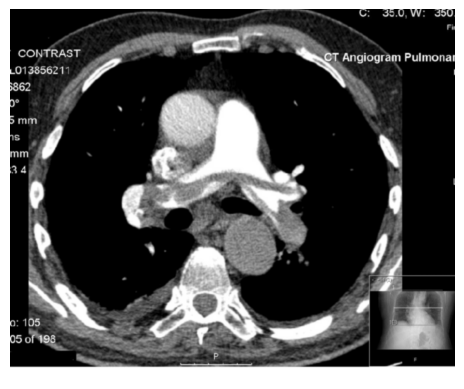

In [47]:
image = None
filename = ''
type = file_selector.value

sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

blur_kernel = np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]]) / 9.0

edge_kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]], dtype='float')

if type == "JPG":
    examples_dir='example-data/png/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
else:
    examples_dir='example-data/dicom/'
    examples_list = [file for file in os.listdir(examples_dir) if file.endswith(('.dcm'))]
    

filename_picker = widgets.Dropdown(
    options=examples_list,
    description="Pick image",
    disabled=False
)

def show(change):
    global dicom_data
    global image
    global filename
    global metadata
    clear_output(wait=True)
    display(filename_picker)
    selected_file = change['new']
    
    if selected_file:
        file_path = os.path.join(examples_dir, selected_file)
    
        if type == "JPG":
            image = mpimg.imread(file_path)
            if len(image.shape) == 3:
                image = np.mean(image, axis=2)
        else:
            dicom_data = pydicom.dcmread(file_path, force=True)
            print(dicom_data)
            
             # Access metadata safely
            

            # Load pixel data
            if hasattr(dicom_data, "pixel_array"):
                image = dicom_data.pixel_array.astype(np.float32)
                image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
                image = image.astype(np.uint8)
            else:
                print("No pixel data found in the DICOM file.")

            

            
            image = dicom_data.pixel_array.astype(np.float32)

            image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
            image = image.astype(np.uint8)
            print(metadata)
        
        if apply_filtering:
            #padding = int(image.shape[0]/2)
            #color=(0, 0, 0)
            #image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
            #image = signal.convolve2d(image, edge_kernel)
            #image = image[2:-2,2:-2]
            image = scipy.ndimage.gaussian_filter(image, sigma=1)
            #image = scipy.ndimage.median_filter(image, size=3)
        
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.show()
        filename = os.path.splitext(filename_picker.value)[0]
        print(filename)

filename_picker.observe(show, names='value')
display(filename_picker)


In [ ]:
def get_dicom_metadata(dicom_data):

    patient_name = dicom_data.PatientName
    patient_id = dicom_data.PatientID
    comments = dicom_data.ImageComments

    metadata = {
        "PatientName": patient_name,
        "PatientID": patient_id,
        "Comments": comments,
    }
    
    return metadata
print(get_dicom_metadata(dicom_data))

{'PatientName': 'Doe^John', 'PatientID': '42', 'Comments': 'what a lovely image we have here...'}


In [16]:
def bresenham_algorithm(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))  
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [27]:
def compute_geometry(shape):
    height, width = shape
    radius = math.floor(math.sqrt(height**2 + width**2) / 2)
    return width // 2, height // 2, radius

In [18]:
step_widget = widgets.IntSlider(value=1, min=1, max=6, step=1, description='Krok ∆α:')
detector_count_widget = widgets.IntSlider(value=180, min=90, max=420, step=10, description='Liczba detektorów:')
span_widget = widgets.IntSlider(value=180, min=90, max=360, step=90, description='Rozwartość (l):')

display(step_widget, detector_count_widget, span_widget)

step = step_widget.value
detector_count = detector_count_widget.value
span = span_widget.value

IntSlider(value=1, description='Krok ∆α:', max=6, min=1)

IntSlider(value=180, description='Liczba detektorów:', max=420, min=90, step=10)

IntSlider(value=180, description='Rozwartość (l):', max=360, min=90, step=90)

In [28]:
def radon_transform(image, step, detectors_num, span, filename):
    step = np.radians(step)  
    span = np.radians(span)
    x_center, y_center, radius = compute_geometry(image.shape)
    sinogram = np.zeros((int(2 * np.pi / step), detectors_num))
    sinogram_snapshot = []
    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = np.array([x_center + radius * np.cos(angle), y_center + radius * np.sin(angle)]).astype(int)
        
        detector_first_pos = angle + np.pi - span / 2
        detector_last_pos = angle + np.pi + span / 2
        det_angles = np.linspace(detector_first_pos, detector_last_pos, detectors_num)
        
        for det_idx, det_angle in enumerate(det_angles):
            det_pos = np.array([x_center + radius * np.cos(det_angle), y_center + radius * np.sin(det_angle)]).astype(int)
            
            rr, cc = line_nd(emitter_pos, det_pos, endpoint=True)
            valid = (0 <= rr) & (rr < image.shape[0]) & (0 <= cc) & (cc < image.shape[1])
            
            bright_points = np.count_nonzero(valid)
            sum_bright = np.sum(image[rr[valid], cc[valid]])
            
            sinogram[i, det_idx] = sum_bright / bright_points if bright_points > 0 else 0

        if i % 10 == 0 or i == sinogram.shape[0] - 1:
            s_scaled = (255.0 / np.amax(sinogram)) * sinogram
            s_scaled = s_scaled.astype(np.uint8)
            s_image = Image.fromarray(s_scaled.T, mode='L')
            s_resized = s_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
            sinogram_snapshot.append(s_resized)

    sinogram_scaled = (255.0 / np.amax(sinogram)) * sinogram
    sinogram_scaled = sinogram_scaled.astype(np.uint8)
    sinogram_image = Image.fromarray(sinogram_scaled.T, mode='L')
    sinogram_resized = sinogram_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
    sinogram_resized.save(f'results/sinograms/{filename}.png')
    plt.imshow(sinogram_resized, cmap="gray")
    plt.axis('off')
    plt.show()

    return sinogram, sinogram_snapshot



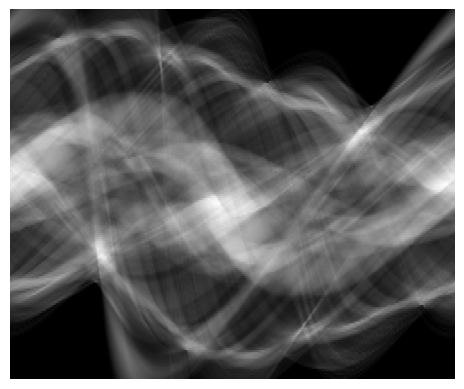

In [29]:
sinogram, sinogram_snapshots = radon_transform(image, step, detector_count, span, filename)

In [10]:
def display_sinogram(step):
    plt.imshow(sinogram_snapshots[step], cmap="gray")
    plt.axis('off')
    plt.show()
    
slider = widgets.IntSlider(value=0, min=0, max=len(sinogram_snapshots) - 1, step=1)
interact(display_sinogram, step=slider)


interactive(children=(IntSlider(value=0, description='step', max=36), Output()), _dom_classes=('widget-interac…

<function __main__.display_sinogram(step)>

In [30]:
def filtruj(sinogram):
    h = np.array([[-1, -1, -1],
                  [-1, 9, -1],
                  [-1, -1, -1],],
                  dtype='float')
    zfiltrowanyObraz = signal.convolve2d(sinogram, h)
    zfiltrowanyObraz = zfiltrowanyObraz[2:-2,2:-2]
    return zfiltrowanyObraz



def inverse_radon_transform(sinogram, image_shape, step, span, filename):
    x_center, y_center, radius = compute_geometry(image_shape)
    step = np.radians(step)
    span = np.radians(span)

    result = np.zeros(image_shape, dtype=np.float64)
    norm_matrix = np.zeros(image_shape, dtype=np.float64)

    output_dir = 'results/template_images/'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = np.array([x_center + radius * np.cos(angle), y_center + radius * np.sin(angle)], dtype=int)

        for j in range(sinogram.shape[1]):
            det_angle = angle + np.pi - span / 2 + j * span / sinogram.shape[1]
            det_pos = np.array([x_center + radius * np.cos(det_angle), y_center + radius * np.sin(det_angle)], dtype=int)

            rr, cc = line_nd(emitter_pos, det_pos, endpoint=True)

            valid_mask = (0 <= rr) & (rr < image_shape[0]) & (0 <= cc) & (cc < image_shape[1])
            valid_rr, valid_cc = rr[valid_mask], cc[valid_mask]

            result[valid_rr, valid_cc] += sinogram[i, j]
            norm_matrix[valid_rr, valid_cc] += 1

        if i % 10 == 0 and np.any(norm_matrix):  
            temp_result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix != 0)
            temp_result_scaled = (255.0 / np.amax(temp_result)) * temp_result if np.amax(temp_result) > 0 else temp_result
            temp_image = Image.fromarray(temp_result_scaled.astype(np.uint8), mode='L')
            temp_image.save(f'{output_dir}step_{i}.png')

    result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix != 0)
    
    result_scaled = (255.0 / np.amax(result)) * result if np.amax(result) > 0 else result
    result_image = Image.fromarray(result_scaled.astype(np.uint8), mode='L')

    output_path = f'results/recovered_images/png/{filename}.png'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    result_image.save(output_path)

    print("Obraz Wyjściowy")
    plt.imshow(result_image, cmap="gray")
    plt.axis('off')
    plt.show()

    return result


Obraz Wyjściowy


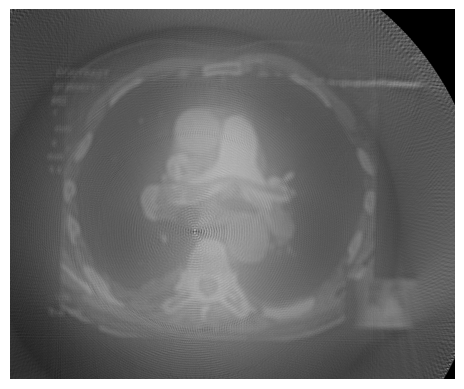

In [31]:
sinogram = filtruj(sinogram)
result = inverse_radon_transform(sinogram, image.shape, 1, 180, filename)
#result = filtruj(result)

In [32]:
print("Postęp generowania obrazu wyjściowegp")
image_folder = "results/template_images/"
def extract_number(filename):
    match = re.search(r"step_(\d+).png", filename)
    return int(match.group(1)) if match else float('inf')

images = sorted(
    [img for img in os.listdir(image_folder) if img.endswith('.png')],
    key=extract_number
)

slider = widgets.IntSlider(min=0, max=len(images)-1, step=1, description="Krok")

def update_image(step):
    img = plt.imread(os.path.join(image_folder, images[step]))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

widgets.interactive(update_image, step=slider)

Postęp generowania obrazu wyjściowegp


interactive(children=(IntSlider(value=0, description='Krok', max=35), Output()), _dom_classes=('widget-interac…

In [13]:
for f in os.listdir(image_folder):
    file_path = os.path.join(image_folder, f)
    if f.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

NameError: name 'image_folder' is not defined

In [33]:
png_dir = "results/recovered_images/png/"
dicom_dir = "results/recovered_images/dicom/"

def save_png(image_array, filename):
    image = Image.fromarray(image_array.astype(np.uint8), mode='L')
    image.save(f"{png_dir}{filename}.png")

def save_dicom(image_array, filename, patient_name, patient_id, date, comment):
    ds = Dataset()
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyDate = date
    ds.ImageComments = comment

    ds.Rows, ds.Columns = image_array.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0

    ds.Modality = "OT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.file_meta = FileMetaDataset()
    ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    ds.file_meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds.PixelData = image_array.tobytes()

    ds.save_as(filename, write_like_original=False)


format_selector = widgets.Dropdown(
    options=["PNG", "DICOM"],
    value="PNG",
    description="Format:",
)

filename_input = widgets.Text(value= filename, description="Nazwa pliku:")
patient_name_input = widgets.Text(description="Pacjent:")
patient_id_input = widgets.Text(description="ID Pacjenta:")
address_input = widgets.Text(description="Adres:")
date_input = widgets.Text(description="Data:")
comment_input = widgets.Text(description="Komentarz:")

dicom_fields = widgets.VBox([
    patient_name_input, patient_id_input, address_input, date_input, comment_input
])

save_button = widgets.Button(description="Zapisz obraz")

def save_image(_):
    filename = filename_input.value
    image_array = np.array(result, dtype=np.uint8)

    if format_selector.value== "PNG":
        save_png(image_array, filename)
    else:
        save_dicom(
            image_array, 
            filename, 
            patient_name_input.value, 
            patient_id_input.value, 
            address_input.value, 
            date_input.value, 
            comment_input.value
        )

save_button.on_click(save_image)

def update_fields(change):
    if format_selector.value == "DICOM":
        dicom_fields.layout.display = 'block'
    else:
        dicom_fields.layout.display = 'none'


dicom_fields.layout.display = 'none'

display(format_selector, filename_input, dicom_fields, save_button)
format_selector.observe(update_fields, names="value")

Dropdown(description='Format:', options=('PNG', 'DICOM'), value='PNG')

Text(value='SADDLE_PE-large', description='Nazwa pliku:')

Button(description='Zapisz obraz', style=ButtonStyle())

In [ ]:
res_dir = 'results/recovered_images/png'

def adjust_brightness(filename, contrast_factor=1.5):
    image_path = os.path.join(res_dir, f'{filename}.png')
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")
    
    adjusted = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    output_path = os.path.join(res_dir, f'{filename}_contrast.png')
    cv2.imwrite(output_path, adjusted)

    plt.imshow(adjusted, cmap='gray')
    plt.axis('off')
    plt.show()

    return adjusted

bright_widget = widgets.FloatSlider(value=1.50, min=1.1, max=7.5, step=0.1, description='Współczynnik jasności:')

def update_brightness(brightness_factor):
    adjust_brightness(filename, brightness_factor)

widgets.interactive(update_brightness, brightness_factor=bright_widget)


interactive(children=(FloatSlider(value=1.5, description='Współczynnik jasności:', max=7.5, min=1.1), Output()…

# Wykonany Eksperyment

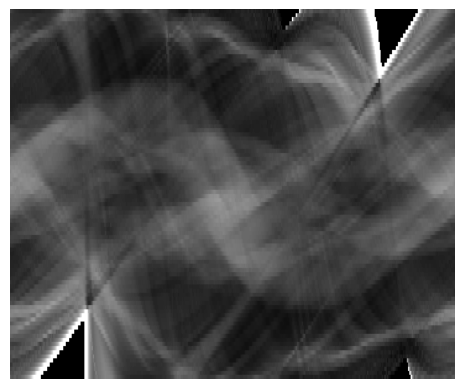

Obraz Wyjściowy


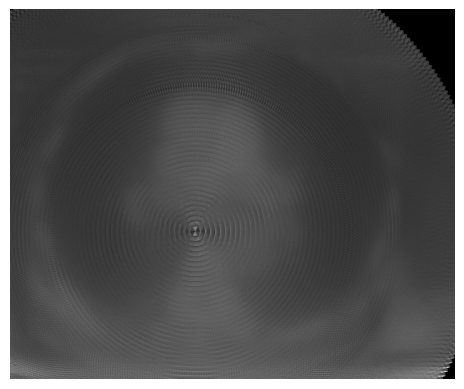

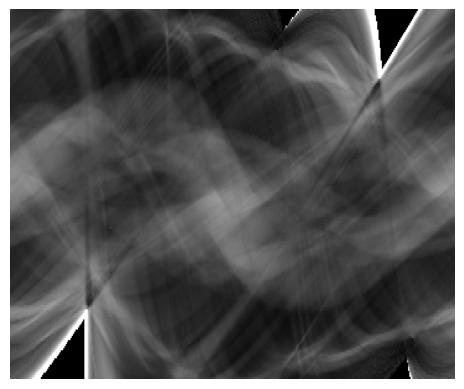

Obraz Wyjściowy


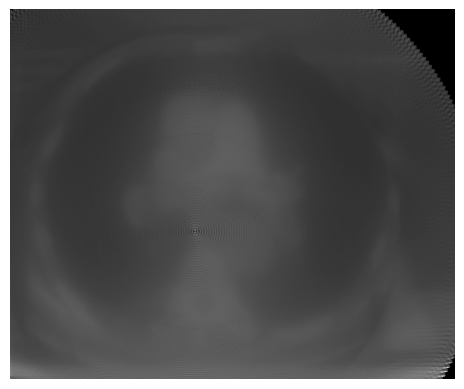

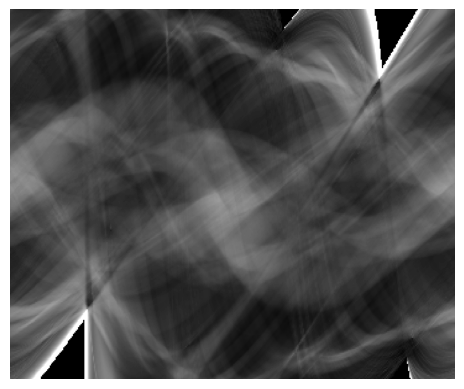

Obraz Wyjściowy


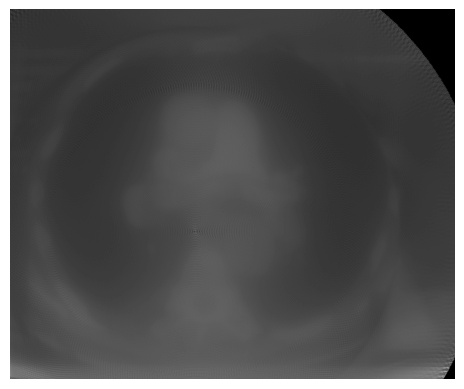

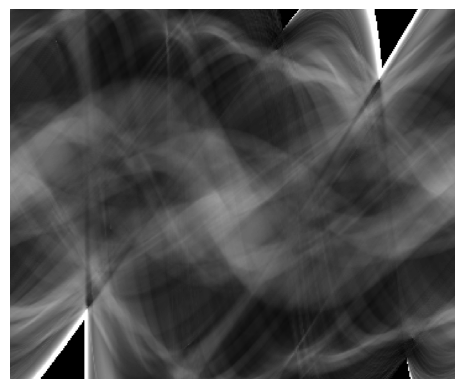

Obraz Wyjściowy


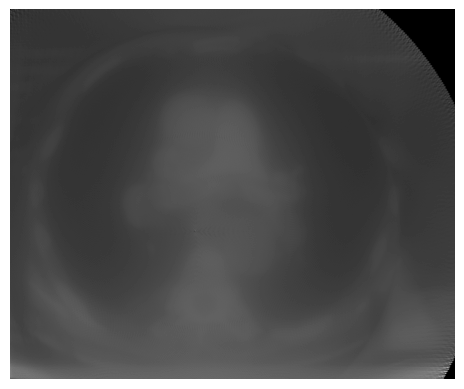

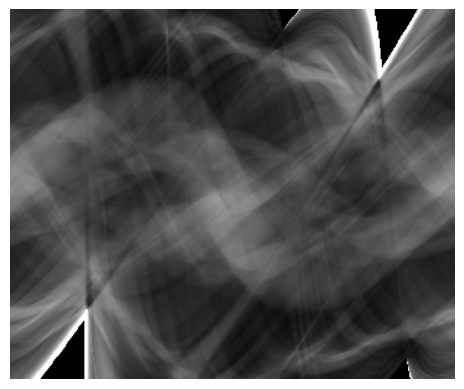

Obraz Wyjściowy


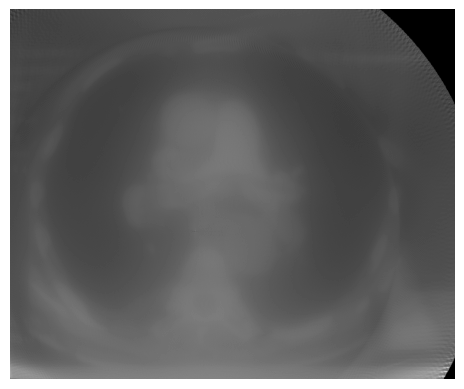

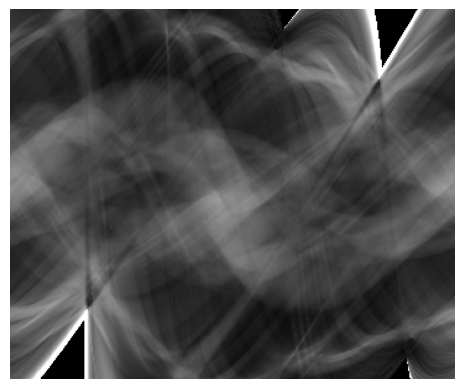

Obraz Wyjściowy


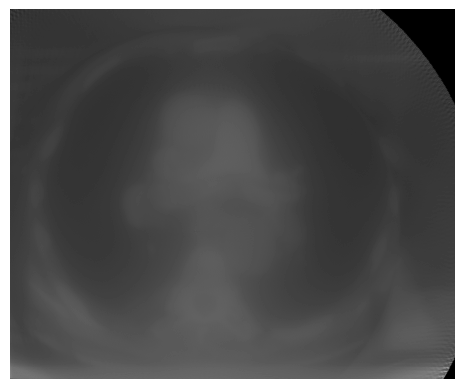

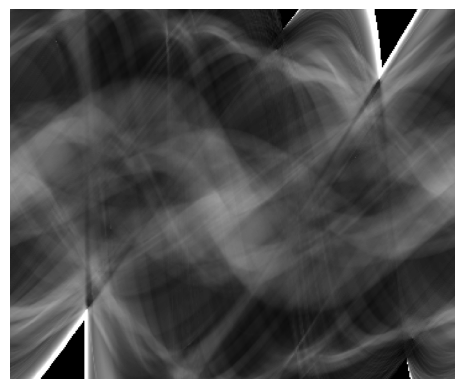

Obraz Wyjściowy


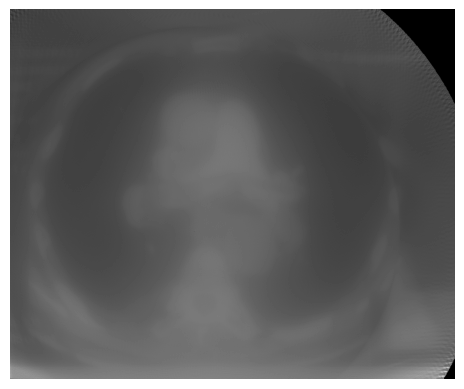

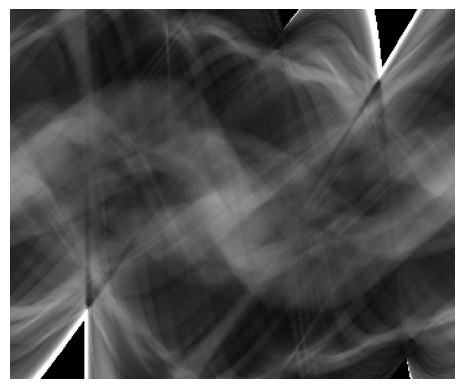

Obraz Wyjściowy


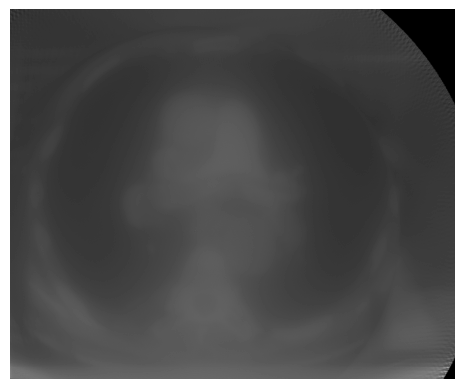

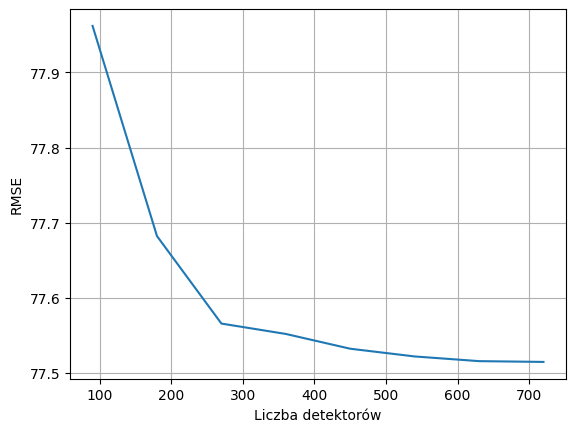

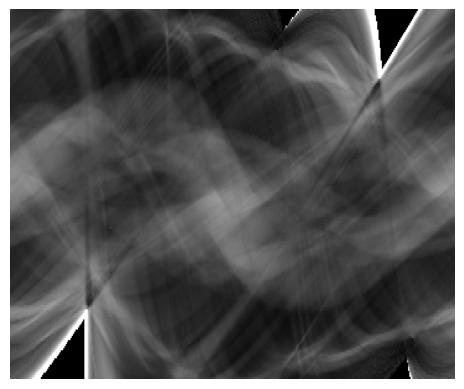

Obraz Wyjściowy


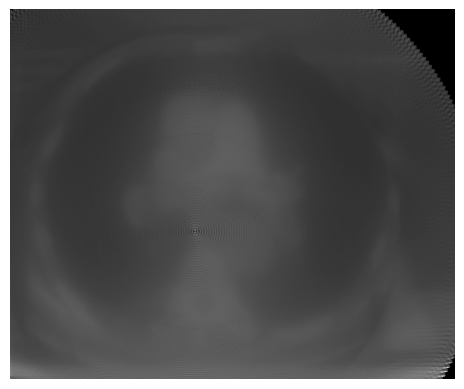

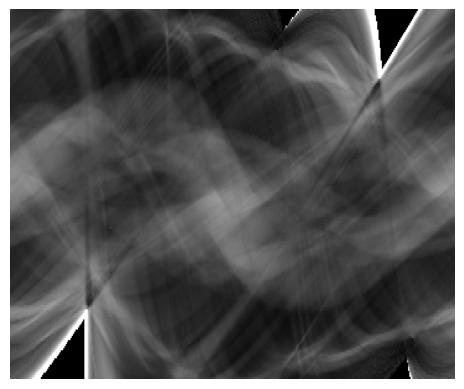

Obraz Wyjściowy


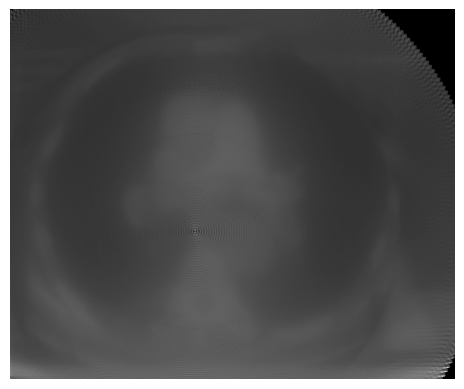

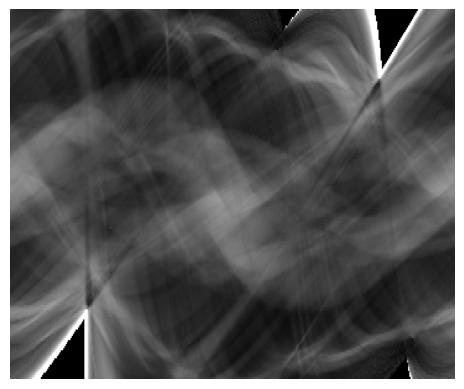

Obraz Wyjściowy


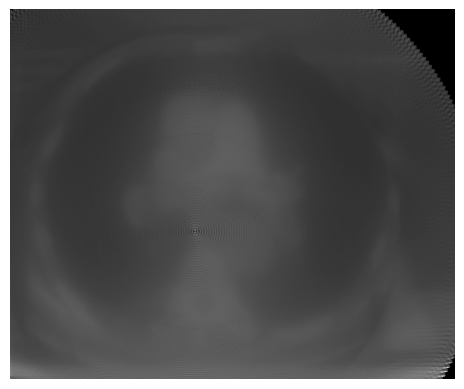

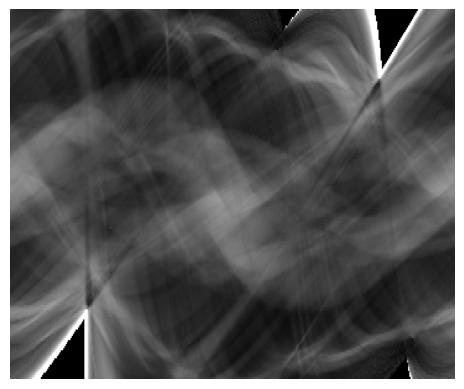

Obraz Wyjściowy


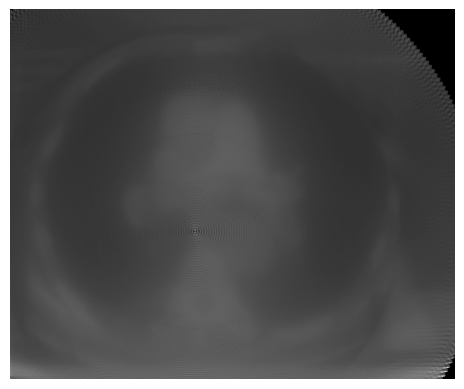

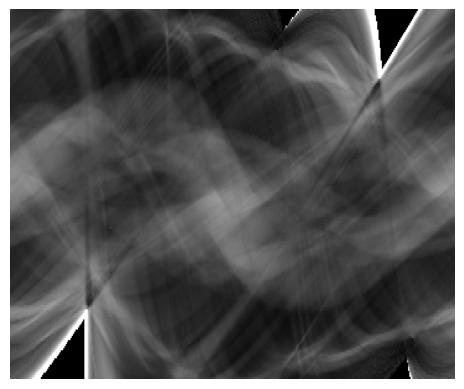

Obraz Wyjściowy


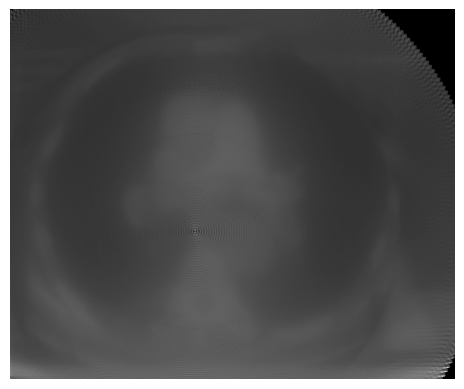

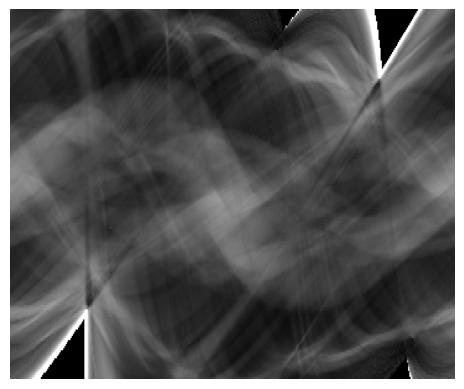

Obraz Wyjściowy


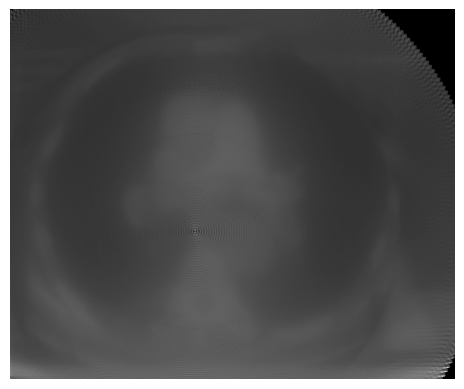

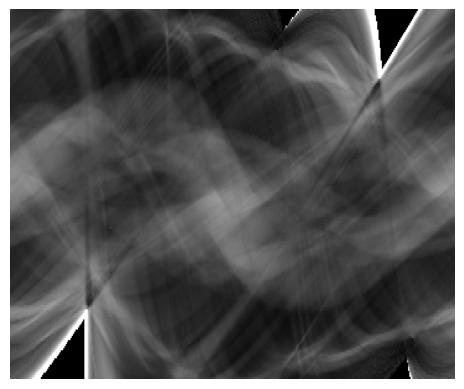

Obraz Wyjściowy


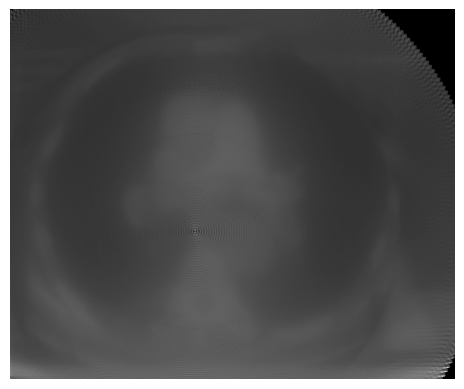

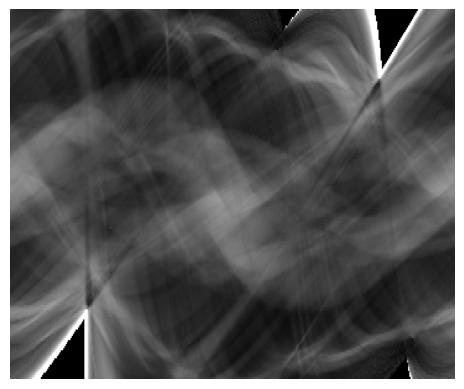

Obraz Wyjściowy


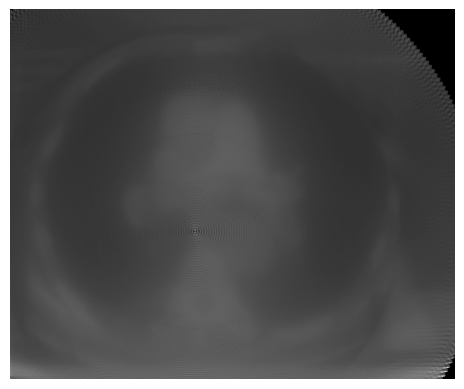

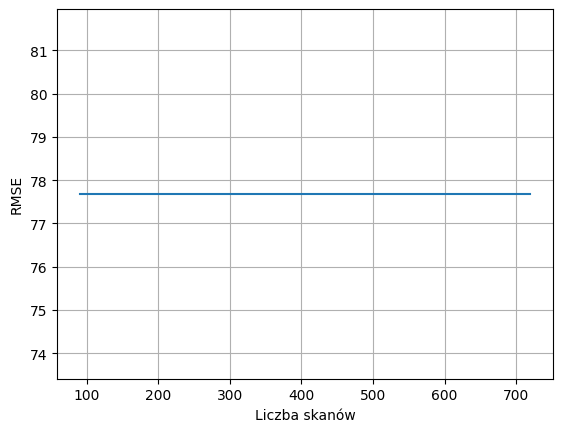

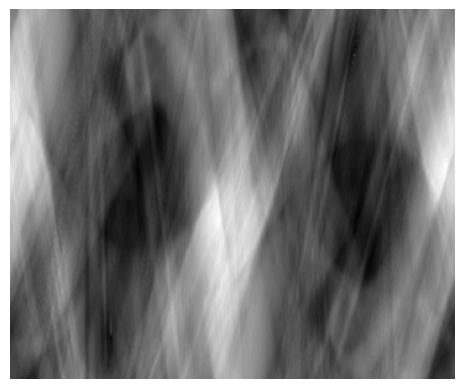

Obraz Wyjściowy


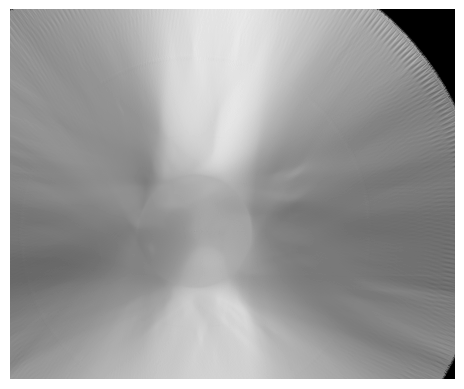

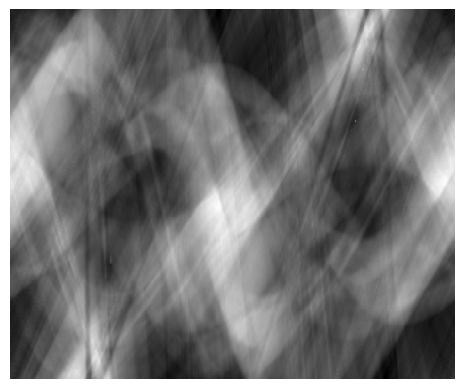

Obraz Wyjściowy


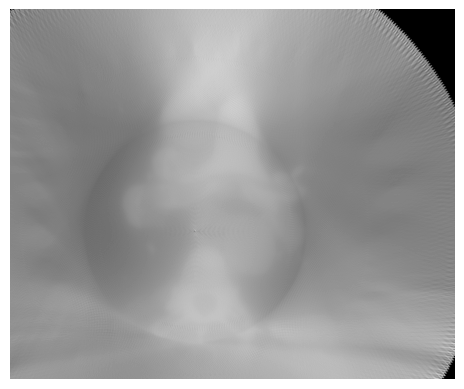

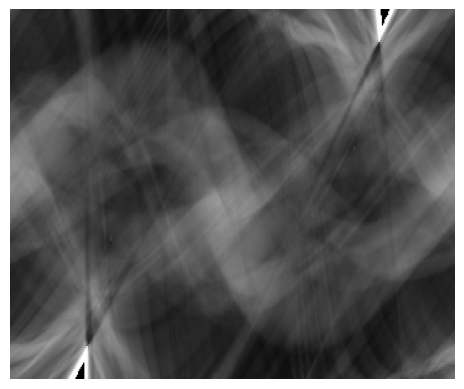

Obraz Wyjściowy


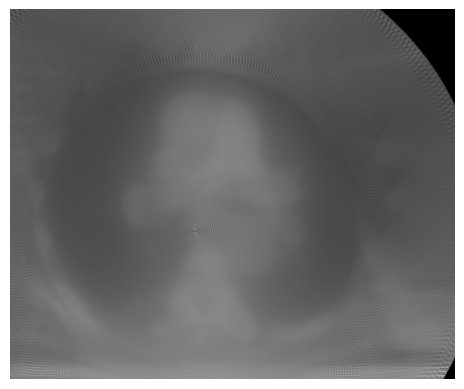

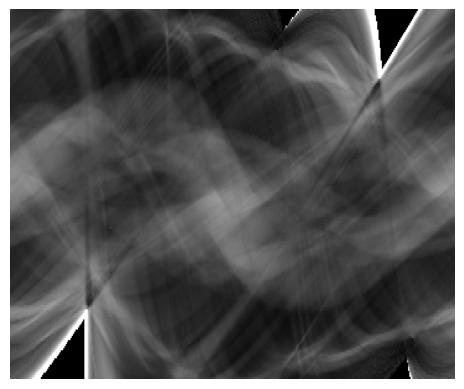

Obraz Wyjściowy


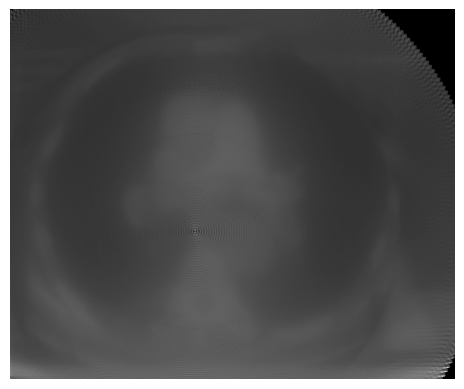

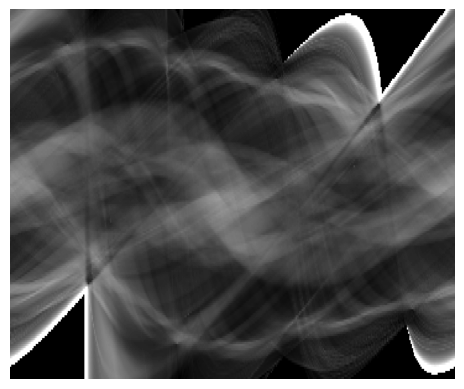

Obraz Wyjściowy


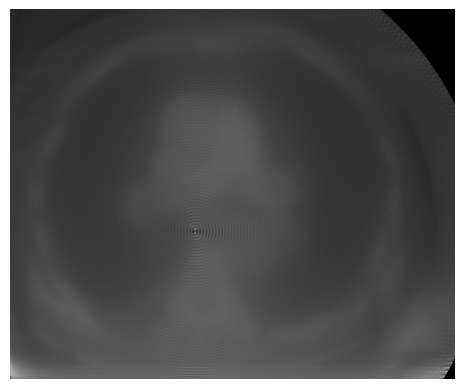

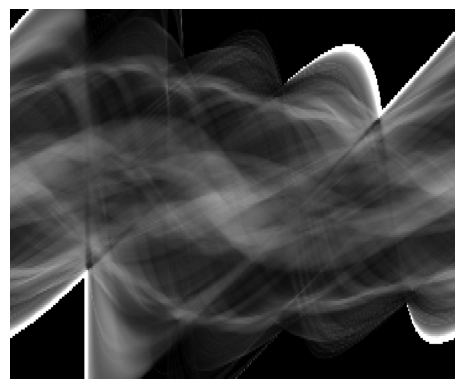

Obraz Wyjściowy


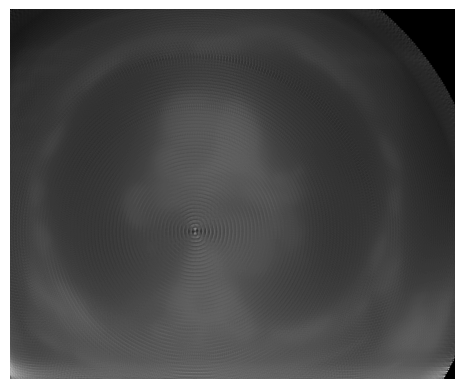

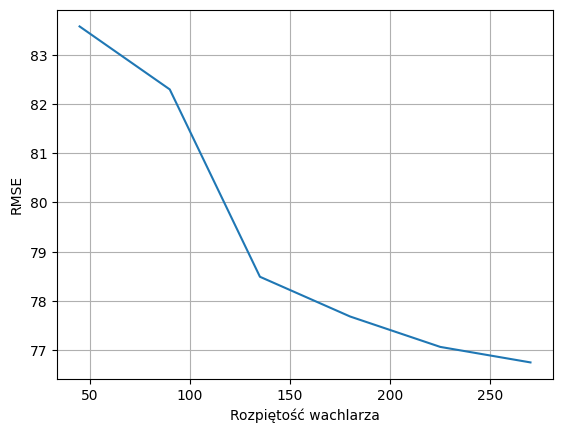

In [37]:
### BASIC ###
# dets - 180
# scans - 180
# fan - 180

dets = [i for i in range(90, 721, 90)]
scans = [i for i in range(90, 721, 90)]
fans = [i for i in range(45, 271, 45)]

rmse_dets = []
rmse_scans = []
rmse_fans = []

# test_img = np.array(Image.open("./example-data/png/Shepp_logan.jpg").convert("L"))
test_img = mpimg.imread("./example-data/png/SADDLE_PE.jpg")
if len(test_img.shape) == 3:
    test_img = np.mean(test_img, axis=2)

def calc_RMSE(org, rec):
    return np.sqrt(np.mean((org - rec) ** 2))

for d in dets:
    sin = radon_transform(test_img, 1, d, 180, 180)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180,'TEST')
    rmse = calc_RMSE(test_img, rec)
    rmse_dets.append(rmse)

plt.figure()
plt.plot(dets, rmse_dets, label='RMSE dla detektorów')
plt.xlabel('Liczba detektorów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for s in scans:
    sin = radon_transform(test_img, 1, 180, 180, s)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, 180,'TEST')
    rmse = calc_RMSE(test_img, rec)
    rmse_scans.append(rmse)

plt.figure()
plt.plot(scans, rmse_scans, label='RMSE dla skanów')
plt.xlabel('Liczba skanów')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

for f in fans:
    sin = radon_transform(test_img, 1, 180, f, 180)[0]
    rec = inverse_radon_transform(sin, test_img.shape, 1, f,'TEST')
    rmse = calc_RMSE(test_img, rec)
    rmse_fans.append(rmse)

plt.figure()
plt.plot(fans, rmse_fans, label='RMSE dla rozpętości wachlarza')
plt.xlabel('Rozpiętość wachlarza')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


